# Music Generation - Siddharth Shah, Ian Pompliano

Artificial Neural Networks and Deep Learning Final Project (Fall 2023)

**Part 1: Scrape MIDI files.**

In [1]:
import requests
import os
from bs4 import BeautifulSoup
from music21 import *

In [2]:
# list of composers
composers = ["albeniz", "bach", "balak", "beeth", "borodin", "brahms", "burgm",
             "chopin", "clementi", "debuss", "godowsky", "grana", "grieg", "haydn",
             "liszt", "mendelssohn", "moszkowski", "mozart", "muss", "rach", "ravel",
             "schub", "schum", "sinding", "tschai"]

baseURL = 'http://www.piano-midi.de/'

# create a directory to save downloaded MIDI files
if not os.path.exists('midiFiles'):
    os.makedirs('midiFiles')

for composer in composers:
    # create URL using respective composer
    url = baseURL + composer + '.htm'
    response = requests.get(url)

    soup = BeautifulSoup(response.content, 'html.parser')

    # Find MIDI links on the composer's page
    midiLinks = soup.find_all('a', href=True)

    for link in midiLinks:
        # removes duplicate MIDI files (special format0)
        if link['href'].endswith('.mid') and '_format0' not in link['href']:
            midiURL = baseURL + link['href']
            fileName = f"midiFiles/{composer}_{link['href'].split('/')[-1]}"

            # download MIDI file and save it to directory
            with open(fileName, 'wb') as midiFile:
                midiResponse = requests.get(midiURL)
                midiFile.write(midiResponse.content)

**Part 2: Organize notes in each MIDI file. Create list of sublists containing notes for each song**

In [2]:
# helper function to get the notes in a given MIDI file
def getNotes(file):
    # initalize list of notes to return
    notes = []
    pick = file.recurse()

    for element in pick:
        # if element is note, add to list of notes
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        # if element is chord, add highest pitch (generally belongs to melody) to list of notes.
        elif isinstance(element, chord.Chord):
            highestPitch = max(element.pitches)
            notes.append(str(highestPitch))
    return notes

In [ ]:
# initialize list that will hold sub-lists of notes for each song
allNotes = []

# retrieve paths of MIDI files
midiFiles = [os.path.join('midiFiles', file) for file in os.listdir('midiFiles') if file.endswith('.mid')]

# append allNotes with note data for each song
for path in midiFiles:
    midi = converter.parse(path)
    notes = getNotes(midi)
    allNotes.append(notes)

/Users/siddharthshah/anaconda3/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2007 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/Users/siddharthshah/anaconda3/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1998 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
/Users/siddharthshah/anaconda3/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2004 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
/Users/siddharthshah/anaconda3/lib/python3.11/site-packages/music21/midi/translate.p

**Part 2.5: Visualize songs from corpus on sheet music**

In [5]:
# import necessary libraries
import IPython
from IPython.display import Image

In [6]:
# helper functions
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

In [40]:
# sample first 50 notes from first song in corpus
sample_notes = allNotes[0][:50]

# execute helper functions for sheet music display
melody_snippet = chords_n_notes(sample_notes)
show(melody_snippet)

LilyTranslateException: Cannot find a copy of Lilypond installed on your system. Please be sure it is installed. And that your environment.UserSettings()['lilypondPath'] is set to find it.

**Part 3: Map notes for each song to strings with normalized characters**


In [2]:
# function maps individual notes to specific integers for one-hot encoding.
# note that, for example, both C#2 and D-2 map to '#'. This is because
# these two notes are the same pitch, but may be represented differently
# in musical notation. D- indicates D flat.
def mapNote(note):
    
    noteMapping = {
        'C2': 0, 'C#2': 1, 'D-2': 1, 'D2': 2, 'D#2': 3, 'E-2': 3, 'E2': 4, 'F2': 5, 'F#2': 6,
        'G-2': 6, 'G2': 7, 'G#2': 8, 'A-2': 8, 'A2': 9, 'A#2': 10, 'B-2': 10, 'B2': 11,
        'C3': 12, 'C#3': 13, 'D-3': 13, 'D3': 14, 'D#3': 15, 'E-3': 15, 'E3': 16, 'F3': 17, 'F#3': 18,
        'G-3': 18, 'G3': 19, 'G#3': 20, 'A-3': 20, 'A3': 21, 'A#3': 22, 'B-3': 22, 'B3': 23,
        'C4': 24, 'C#4': 25, 'D-4': 25, 'D4': 26, 'D#4': 27, 'E-4': 27, 'E4': 28, 'F4': 29, 'F#4': 30,
        'G-4': 30, 'G4': 31, 'G#4': 32, 'A-4': 32, 'A4': 33, 'A#4': 34, 'B-4': 34, 'B4': 35,
        'C5': 36, 'C#5': 37, 'D-5': 37, 'D5': 38, 'D#5': 39, 'E-5': 39, 'E5': 40, 'F5': 41, 'F#5': 42,
        'G-5': 42, 'G5': 43, 'G#5': 44, 'A-5': 44, 'A5': 45, 'A#5': 46, 'B-5': 46, 'B5': 47,
        'C6': 48, 'C#6': 49, 'D-6': 49, 'D6': 50, 'D#6': 51, 'E-6': 51, 'E6': 52, 'F6': 53, 'F#6': 54,
        'G-6': 54, 'G6': 55, 'G#6': 56, 'A-6': 56, 'A6': 57, 'A#6': 58, 'B-6': 58, 'B6': 59,
        'C7': 60, 'C#7': 61, 'D-7': 61, 'D7': 62, 'D#7': 63, 'E-7': 63, 'E7': 64, 'F7': 65, 'F#7': 66,
        'G-7': 66, 'G7': 67, 'G#7': 68, 'A-7': 68, 'A7': 69, 'A#7': 70, 'B-7': 70, 'B7': 71,
        'C8': 72, 'C#8': 73, 'D-8': 73, 'D8': 74, 'D#8': 75, 'E-8': 75, 'E8': 76, 'F8': 77, 'F#8': 78,
        'G-8': 78, 'G8': 79, 'G#8': 80, 'A-8': 80, 'A8': 81, 'A#8': 82, 'B-8': 82, 'B8': 83,
        'B-1': 84, 'A0': 85, 'A#0': 86, 'B0': 87, 'C1': 88, 'C#1': 89, 'D1': 90, 'D#1': 91, 'E1': 92,
        'E-1': 93, 'F1': 94, 'F#1': 95, 'G1': 96, 'G#1': 97,
        'A1': 98, 'B-0': 99, 'B1': 100,
    }

    return noteMapping.get(note, note)

In [27]:
# Example usage:
note_as_integer = mapNote('C#3')
print(note_as_integer)


13


In [11]:
# IGNORE OLD
# initialize list of strings where each char in string is a mapped note. Each string represents one song
allNotesMapped = []

# iterate through all songs in allNotes list
for i in range(len(allNotes)):
    buildString = ""
    
    # iterate through raw note data for each song, map note to respective char, add char to song string
    for j in range(len(allNotes[i])):
        buildString += mapNote(allNotes[i][j])
    
    # append list of strings with built string
    allNotesMapped.append(buildString)

TypeError: can only concatenate str (not "int") to str

In [12]:
# initialize list of songs where each song is represented as a list of int-mapped notes
mapped_songs = []

# iterate through all songs in allNotes list
for i in range(len(allNotes)):
    song_lst = []
    
    # iterate through raw note data for each song, map note to respective char, add char to song string
    for j in range(len(allNotes[i])):
        song_lst.append(mapNote(allNotes[i][j]))
    
    # append list of strings with built string
    mapped_songs.append(song_lst)

**Optional: Pickle library to store and reload allNotesMapped**

In [13]:
# pickle and Download mapped_songs for future reference
import pickle as pkl

with open('mapped_songs.pkl', 'wb') as file:
    pkl.dump(mapped_songs, file)

In [3]:
# pickle to reload mapped_songs
import pickle as pkl

# unpickle the data structure from the file
with open('mapped_songs.pkl', 'rb') as file:
    mapped_songs = pkl.load(file)

In [4]:
# confirm mapped songs follows most updated notes mapping dictionary
notes_set = set()
for song in mapped_songs:
    for note in song:
        notes_set.add(note)
        
print(notes_set)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 84, 85, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100}


**Part 4: Split Dataset and Train the Network**

In [5]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers.legacy import Adamax

In [7]:
# mapped_songs -- array of songs representing lists of notes mapped to arbitrary integers
all_notes = mapped_songs

# split corpus into labels and targets
seq_length = 40 # arbitrarily choose input sequences of length 40
features = []
targets = []

for song in all_notes: 
    for i in range(0, len(song) - seq_length, 1):
        features.append(song[i:i + seq_length])
        targets.append([song[i + seq_length]]*seq_length)

In [8]:
# display summary statistics
num_sequences = len(targets)
num_classes = 101 # obtained from mapping

# dimensions of X input tensor
print(f"num sequences: {num_sequences}")
print(f"sequence length: {seq_length}")
print(f"num classes: {num_classes}")

num sequences: 519046
sequence length: 40
num classes: 101


In [9]:
# reshape and one hot encode both X sequences and Y target output
X = np.reshape(features, (num_sequences, seq_length, 1))
X = tf.keras.utils.to_categorical(X, num_classes=num_classes)

y = np.reshape(targets, (num_sequences, seq_length, 1))
y = tf.keras.utils.to_categorical(y, num_classes=num_classes)


In [10]:
# confirm the shape of the input tensors
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (519046, 40, 101)
y shape: (519046, 40, 101)


In [11]:
# split labels and targets into training and seed data
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# visualize first element of X_seed
for row in range(seq_length):
    for col in range(num_classes):
        print(X_seed[0,row,col], end=" ")
    print("\n\n")
    

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 


0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 


0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.

In [13]:
# confirm the shapes of the dataset split
print(f"X_seed shape: {X_seed.shape}")
print(f"y_seed shape: {y_seed.shape}")

X_seed shape: (103810, 40, 101)
y_seed shape: (103810, 40, 101)


In [14]:
# initialize the model
model = Sequential()

# additional layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Dense(num_classes, activation='softmax')) # final ouput is num_classes PDF

# compile the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['categorical_crossentropy', 'accuracy'])

In [15]:
# display model summary               
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1257472   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 40, 256)           787456    
                                                                 
 dropout_1 (Dropout)         (None, 40, 256)           0         
                                                                 
 dense (Dense)               (None, 40, 128)           32896     
                                                                 
 dense_1 (Dense)             (None, 40, 101)           13029     
                                                                 
Total params: 2090853 (7.98 MB)
Trainable params: 209085

In [16]:
# Train the Model
history = model.fit(X_train[:,:,:], y_train[:,:,:], batch_size=1024, epochs=50)

Epoch 1/5
49/49 [==============================] - 95s 2s/step - loss: 4.0622 - categorical_crossentropy: 4.0622 - accuracy: 0.0400
Epoch 2/5
49/49 [==============================] - 97s 2s/step - loss: 3.8485 - categorical_crossentropy: 3.8485 - accuracy: 0.0456
Epoch 3/5
49/49 [==============================] - 95s 2s/step - loss: 3.7987 - categorical_crossentropy: 3.7987 - accuracy: 0.0466
Epoch 4/5
49/49 [==============================] - 102s 2s/step - loss: 3.7173 - categorical_crossentropy: 3.7173 - accuracy: 0.0521
Epoch 5/5
49/49 [==============================] - 91s 2s/step - loss: 3.6810 - categorical_crossentropy: 3.6810 - accuracy: 0.0543


[Text(0.5, 0, 'Epochs')]

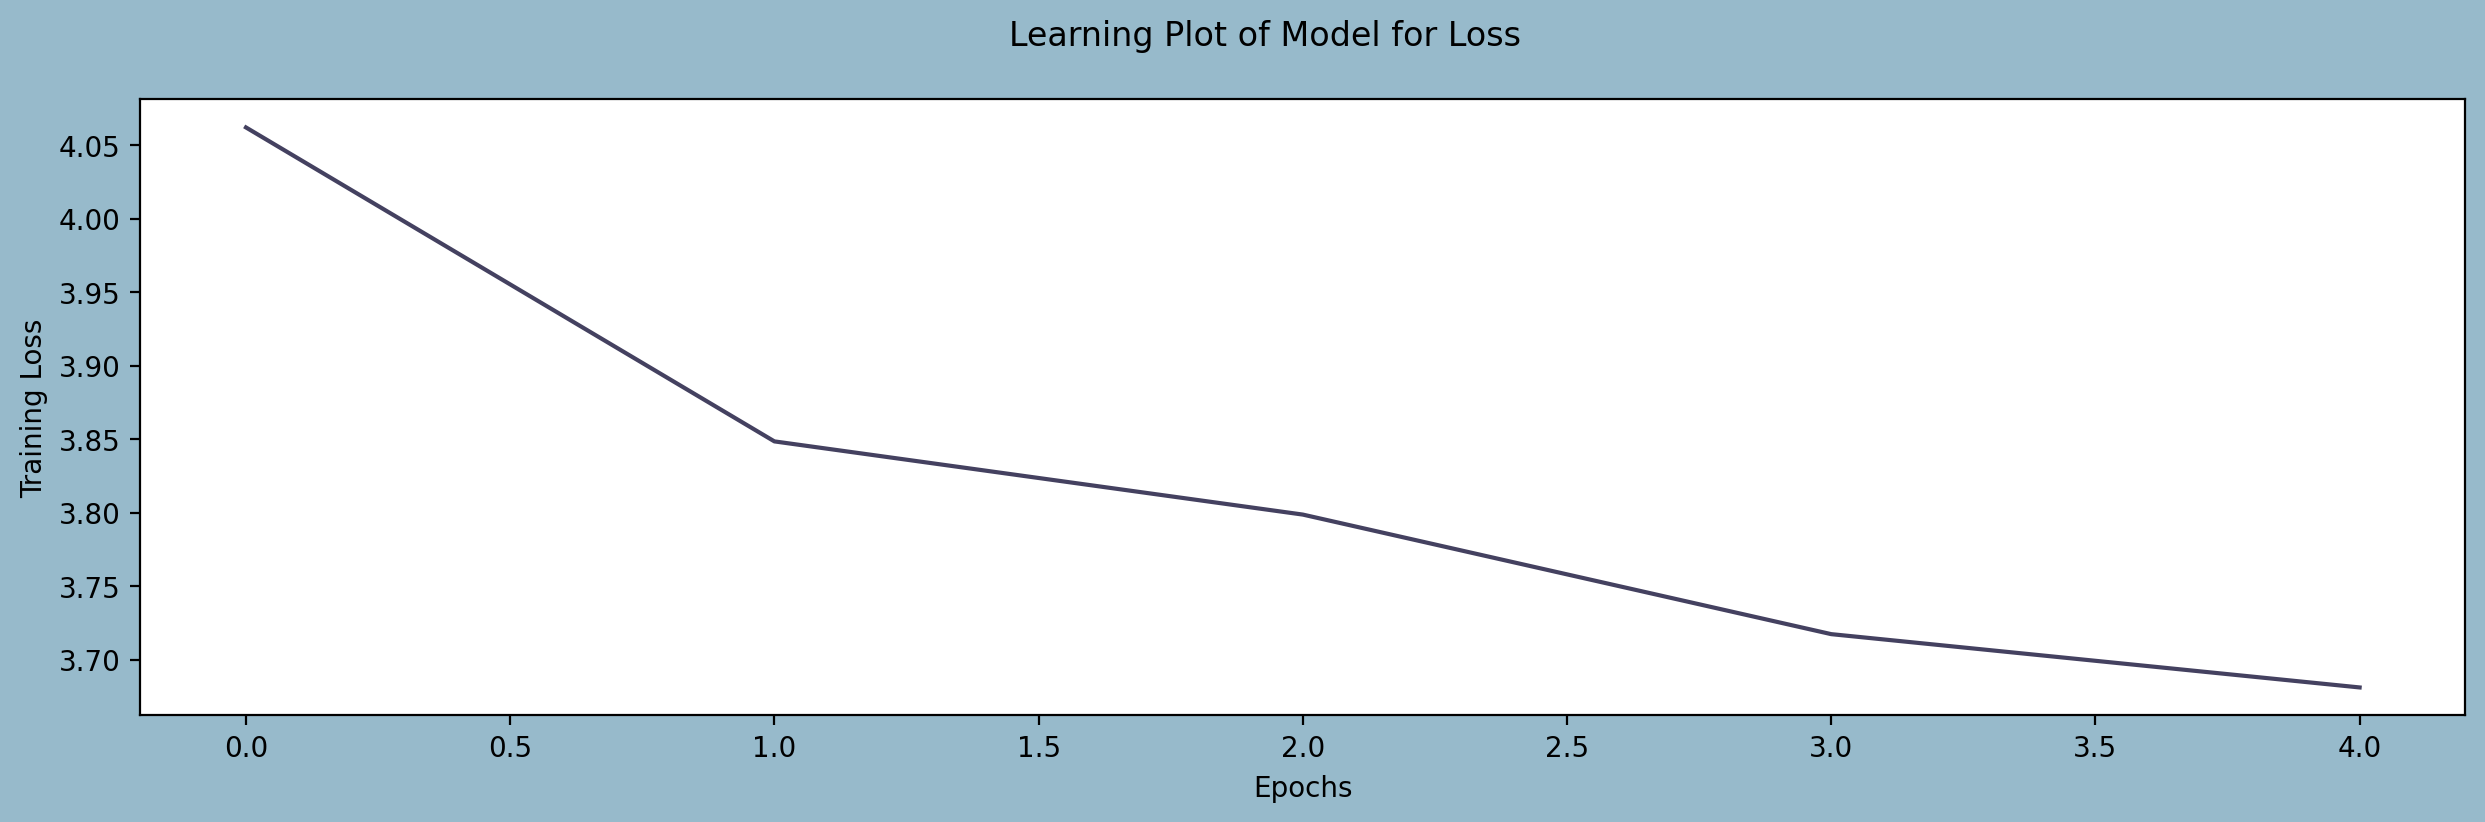

In [17]:
# Plot learning via loss function
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

**Part 5: Generate sample music from model predictions**

In [18]:
# function that will convert integers in produced sequence string back to note notation.
# note that here, we omit flats, because we can represent all flat pitches as sharps as well
# i.e. A flat is the same as G#, Db is the same as C#
def reverseMap(note):
    
    reverseNoteMapping = {
        0: 'C2', 1: 'C#2', 2: 'D2', 3: 'D#2', 4: 'E2', 5: 'F2', 6: 'F#2',
        7: 'G2', 8: 'G#2', 9: 'A2', 10: 'A#2', 11: 'B2', 12: 'C3', 13: 'C#3',
        14: 'D3', 15: 'D#3', 16: 'E3', 17: 'F3', 18: 'F#3', 19: 'G3', 20: 'G#3',
        21: 'A3', 22: 'A#3', 23: 'B3', 24: 'C4', 25: 'C#4', 26: 'D4', 27: 'D#4',
        28: 'E4', 29: 'F4', 30: 'F#4', 31: 'G4', 32: 'G#4', 33: 'A4', 34: 'A#4',
        35: 'B4', 36: 'C5', 37: 'C#5', 38: 'D5', 39: 'D#5', 40: 'E5', 41: 'F5',
        42: 'F#5', 43: 'G5', 44: 'G#5', 45: 'A5', 46: 'A#5', 47: 'B5', 48: 'C6',
        49: 'C#6', 50: 'D6', 51: 'D#6', 52: 'E6', 53: 'F6', 54: 'F#6', 55: 'G6',
        56: 'G#6', 57: 'A6', 58: 'A#6', 59: 'B6', 60: 'C7', 61: 'C#7', 62: 'D7',
        63: 'D#7', 64: 'E7', 65: 'F7', 66: 'F#7', 67: 'G7', 68: 'G#7', 69: 'A7',
        70: 'A#7', 71: 'B7', 72: 'C8', 73: 'C#8', 74: 'D8', 75: 'D#8', 76: 'E8',
        77: 'F8', 78: 'F#8', 79: 'G8', 80: 'G#8', 81: 'A8', 82: 'A#8', 83: 'B8',
        84: 'B-1', 85: 'A0', 86: 'A#0', 87: 'B0', 88: 'C1', 89: 'C#1', 90: 'D1',
        91: 'D#1', 92: 'E1', 93: 'E-1', 94: 'F1', 95: 'F#1', 96: 'G1', 97: 'G#1',
        98: 'A1', 99: 'B-0', 100: 'B1',
    }
    
    return reverseNoteMapping.get(note, note)

In [19]:
# helper function to sample an index from a probability array
# input parameters are preds (1D probability distribution) and temperature (diversity)
# pulled from week6_exercises with RNNs
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.exp(np.log(preds) / temperature)  # softmax
    preds = preds / np.sum(preds)                #
    probas = np.random.multinomial(1, preds, 1)  # sample index
    return np.argmax(probas)   


In [20]:
# helper function employing model predictions to generate new melodies
# input params are seed of shape (seq_length, num_classes), number of notes, and diversity value
# inspired in part from week 
def generate_music(seed, num_notes, diversity):
    notes_generated = []

    # add seed notes at beginning
    for note_enc in seed:
        notes_generated.append(reverseMap(np.argmax(note_enc)))
        
    for i in range(num_notes):
        # model prediction
        X_pred = seed.reshape(1, seq_length, num_classes)
        y_pred = model.predict(X_pred, verbose=0)

        # helper function to sample the next note_int
        next_note_int = sample(y_pred[0, -1], diversity)

        # reverse map next_note_int and append
        next_note = reverseMap(next_note_int)
        notes_generated.append(next_note)

        # one-hot encode next_note_int
        next_note_encoded = np.zeros(num_classes)
        next_note_encoded[next_note_int] = 1

        # update seed with prediction
        seed = np.append(seed, next_note_encoded.reshape(1, num_classes), axis=0)
        seed = seed[1:,:] # remove first note from sequence
        
    return notes_generated


In [22]:
# pick N random sequences from seed array and generate the next M musical notes
num_samples, num_notes = 20, 20 # N, M
music_samples = []

for _ in range(num_samples):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    diversity = 0.5 # arbitrary
    notes_generated = generate_music(seed, num_notes, diversity)
    music_samples.append(notes_generated)


In [23]:
# visualize first 5 artificially generated music melodies
for sample in music_samples[:5]:
    print(sample, "\n\n")

['A5', 'G5', 'C6', 'C7', 'G6', 'C7', 'A6', 'F6', 'D6', 'C6', 'F6', 'F7', 'D7', 'C7', 'A6', 'F6', 'D6', 'C6', 'F6', 'F7', 'D7', 'C7', 'A6', 'F6', 'D6', 'C6', 'F6', 'F7', 'D7', 'C7', 'A6', 'F6', 'D6', 'C6', 'E6', 'A#6', 'G6', 'A6', 'F6', 'C6', 'F6', 'F#6', 'A5', 'G5', 'G#6', 'A#5', 'A6', 'A6', 'D#4', 'E6', 'C6', 'D5', 'A5', 'A5', 'B4', 'D5', 'C5', 'F5', 'D6', 'G#5'] 


['A4', 'G#4', 'F#4', 'F#4', 'E4', 'A3', 'A3', 'A3', 'B3', 'C#4', 'C#4', 'C#4', 'C#4', 'D4', 'E4', 'E4', 'D3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'D3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'D#3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'C#4', 'C#4', 'A3', 'E2', 'D#4', 'E4', 'A2', 'F3', 'C3', 'D#3', 'G#4', 'A#3', 'A#3', 'A#3', 'D#2', 'F#3', 'G#3', 'F#3', 'E3', 'G3', 'C3', 'A#2'] 


['A#5', 'C#6', 'C6', 'C#6', 'A#5', 'C#6', 'C6', 'C#6', 'D#6', 'C#6', 'C6', 'C#6', 'D#6', 'C#6', 'C6', 'C#6', 'F#6', 'C#6', 'C6', 'C#6', 'F#6', 'C#6', 'C6', 'C#6', 'B5', 'C#6', 'C6', 'C#6', 'B5', 'C#6', 'C6', 'C#6', 'A#5', 'C#6', 'C6', 'C#6', 'A#

In [ ]:
# pickle music_samples for future reference
import pickle as pkl

with open('music_samples.pkl', 'wb') as file:
    pkl.dump(music_samples, file)

**Part 6: Output generated sequences to musical notation and form MIDI file**

In [24]:
# pick random generated music sample
notes_sample = music_samples[np.random.randint(0, len(music_samples)-1)]
print(notes_sample)

['B4', 'G4', 'E4', 'G4', 'B4', 'E4', 'G4', 'B4', 'D#4', 'A4', 'B4', 'D#4', 'A4', 'B4', 'D#4', 'A4', 'B4', 'D#4', 'A4', 'B4', 'E4', 'G4', 'B4', 'E4', 'G4', 'B4', 'E4', 'G4', 'B4', 'E4', 'G4', 'B4', 'D#4', 'A4', 'B4', 'D#4', 'A4', 'B4', 'D#4', 'A4', 'D4', 'B4', 'C5', 'A4', 'E5', 'A4', 'B4', 'D5', 'G5', 'F4', 'B4', 'A#4', 'D5', 'G4', 'G#4', 'F#5', 'D#4', 'D4', 'G5', 'F#4']


In [25]:
# resolve note declaration
from music21 import note

# create MIDI file
noteStream = stream.Stream()

for n in notes_sample:
    noteObj = note.Note(n)
    noteStream.append(noteObj)

noteStream.append(tempo.MetronomeMark(number=120))
midiFile = noteStream.write('midi', fp='test.mid')

In [26]:
# Load MIDI file using Music21
midiStream = converter.parse('test.mid')

# show musical notation
#midiStream.show()

In [27]:
# produce playable audio
midiStream.show("midi")